In [2]:
#following from this tutorial: http://learn.astropy.org/rst-tutorials/FITS-cubes.html

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60

from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

In [3]:
# Downloads the HI data in a fits file format
hi_datafile = download_file(
    'http://data.astropy.org/tutorials/FITS-cubes/reduced_TAN_C14.fits',
    cache=True, show_progress=True)

In [4]:
hi_data = fits.open(hi_datafile)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

In [5]:
print(cube)

SpectralCube with shape=(450, 150, 150) and unit=K:
 n_x:    150  type_x: GLON-TAN  unit_x: deg    range:   286.727203 deg:  320.797623 deg
 n_y:    150  type_y: GLAT-TAN  unit_y: deg    range:   -50.336450 deg:  -28.401234 deg
 n_s:    450  type_s: VRAD      unit_s: m / s  range:  -598824.534 m / s:  600409.133 m / s


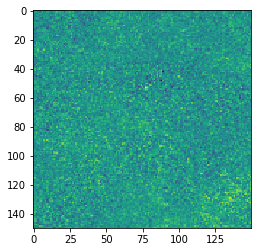

In [20]:
cube[210, :, :].quicklook()  # Slice the cube along the spectral axis, and display a quick image
#cube[200, :, :].quicklook()

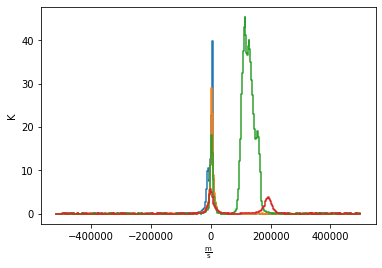

In [19]:
cube[:, 145, 75].quicklook()  # Extract a single spectrum through the data cube
cube[:, 100, 75].quicklook()
cube[:, 50, 75].quicklook()
cube[:, 30, 100].quicklook()

In [21]:
#make subcube focusing on the megellanic clouds
#extract just along two axis in one dimension to avoid extracting a huge amount of data:

_, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :]  #extract longitude world coordinates from cube

In [22]:
# Define desired latitude and longitude range
lat_range = [-46, -40] * u.deg
lon_range = [306, 295] * u.deg

# Create a sub_cube cut to these coordinates
sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])

print(sub_cube)

SpectralCube with shape=(450, 41, 48) and unit=K:
 n_x:     48  type_x: GLON-TAN  unit_x: deg    range:   295.647485 deg:  305.831248 deg
 n_y:     41  type_y: GLAT-TAN  unit_y: deg    range:   -47.080781 deg:  -40.745361 deg
 n_s:    450  type_s: VRAD      unit_s: m / s  range:  -598824.534 m / s:  600409.133 m / s


In [23]:
sub_cube_slab = sub_cube.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)

print(sub_cube_slab)

SpectralCube with shape=(226, 41, 48) and unit=K:
 n_x:     48  type_x: GLON-TAN  unit_x: deg    range:   295.647485 deg:  305.831248 deg
 n_y:     41  type_y: GLAT-TAN  unit_y: deg    range:   -47.080781 deg:  -40.745361 deg
 n_s:    226  type_s: VRAD      unit_s: m / s  range:  -299683.842 m / s:  301268.441 m / s


In [24]:
#MAKING 'MOMENT MAPS'--SHOW total quality (i.e. density, velocity) in a given line of sight
moment_0 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
moment_1 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits')
# moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ', moment_0.unit)
print('Moment_1 has units of: ', moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  K km / s
Moment_1 has units of:  km / s


In [26]:
print(moment_1.wcs)  # Examine the WCS object associated with the moment map

WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Data size  Bounds
        0       None  None
        1       None  None

World Dim  Physical Type     Units
        0  pos.galactic.lon  deg
        1  pos.galactic.lat  deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes


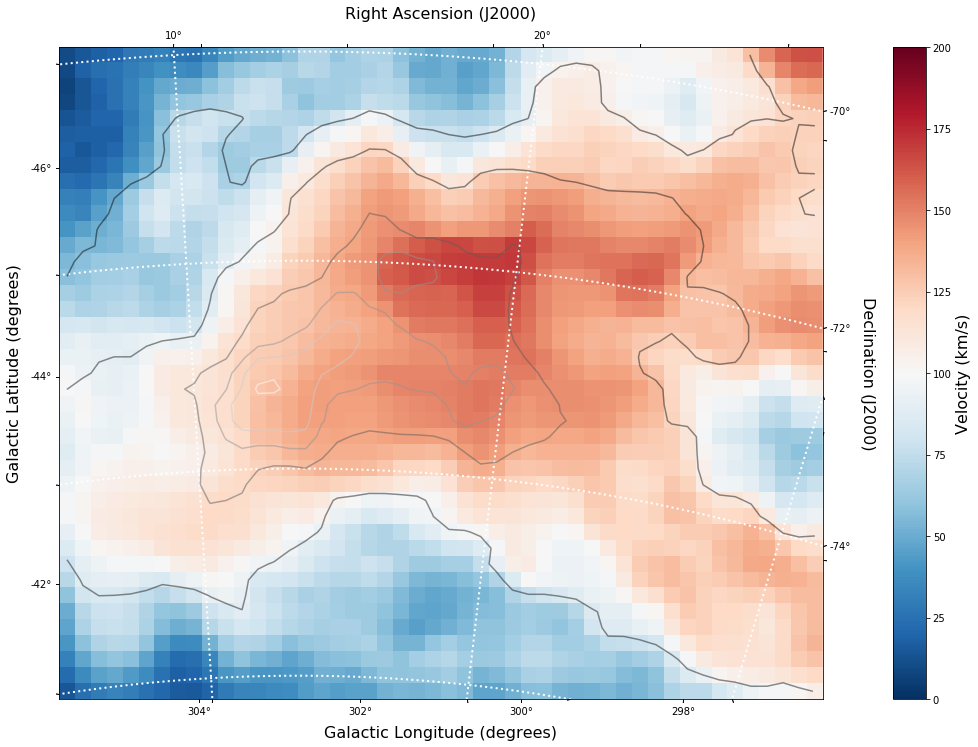

In [27]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=0, vmax=200)
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

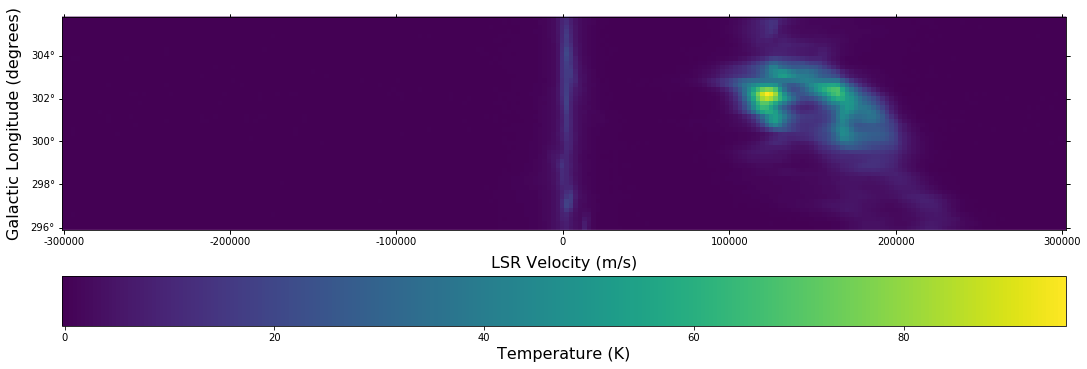

In [29]:
lat_slice = 18  # Index of latitude dimension to slice along

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=sub_cube_slab.wcs, slices=('y', lat_slice, 'x'))
# Above, we have specified to plot the longitude along the y axis, pick only the lat_slice
# indicated, and plot the velocity along the x axis

# Display the slice
im = ax.imshow(sub_cube_slab[:, lat_slice, :].transpose().data)  # Display the image slice
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("LSR Velocity (m/s)", fontsize=16)
ax.set_ylabel("Galactic Longitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Temperature (K)', size=16)

SpectralCube with shape=(38, 41, 48) and unit=K:
 n_x:     48  type_x: GLON-TAN  unit_x: deg    range:   295.647485 deg:  305.831248 deg
 n_y:     41  type_y: GLAT-TAN  unit_y: deg    range:   -47.080781 deg:  -40.745361 deg
 n_s:     38  type_s: VRAD      unit_s: m / s  range:   100951.013 m / s:  199774.278 m / s
Moment_0 has units of:  K km / s
Moment_1 has units of:  km / s


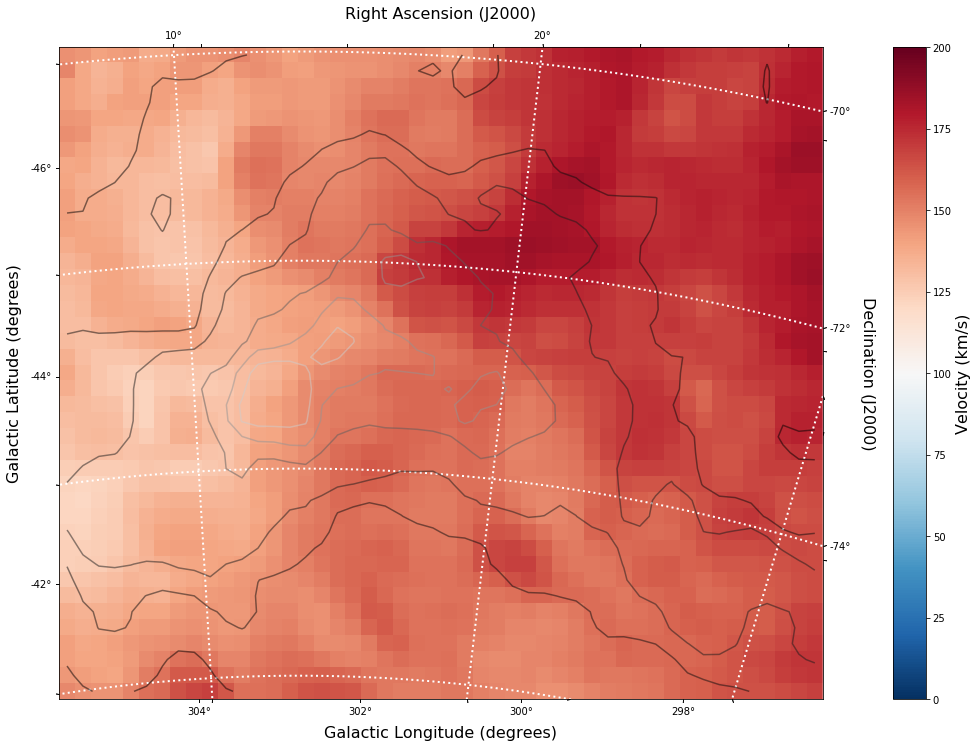

In [31]:
#Create a new spectral slab isolating just the SMC and slice along a different dimension to create 
#a latitude-velocity diagram

sub_cube_slab = sub_cube.spectral_slab(100. *u.km / u.s, 200. *u.km / u.s)

print(sub_cube_slab)

#MAKING 'MOMENT MAPS'--SHOW total quality (i.e. density, velocity) in a given line of sight
moment_0 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
moment_1 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits')
# moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ', moment_0.unit)
print('Moment_1 has units of: ', moment_1.unit)

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=0, vmax=200)
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

In [32]:
# Query for Herschel data in a 1 degree radius around the SMC
result = ESASky.query_region_maps('SMC', radius=1*u.deg, missions='Herschel')

print(result)

TableList with 1 tables:
	'0:HERSCHEL' with 12 column(s) and 28 row(s) 


In [33]:
result['HERSCHEL'].keys()

['postcard_url',
 'product_url',
 'observation_id',
 'observation_oid',
 'ra_deg',
 'dec_deg',
 'target_name',
 'instrument',
 'filter',
 'start_time',
 'duration',
 'stc_s']

In [34]:
result['HERSCHEL']['filter']

"70, 160"
"100, 160"
"70, 160"
"100, 160"
"70, 160"
"70, 160"
"250, 350, 500"
"100, 160"
"70, 160"
"70, 160"
"70, 160"


In [37]:
filters = result['HERSCHEL']['filter'].astype(str)  # Convert the list of filters from the query to a string

# Construct a boolean mask, searching for only the desired filters
mask = np.array(['250, 350, 500' == s for s in filters], dtype='bool')

# Re-construct a new TableList object containing only our desired query entry
target_obs = TableList({"HERSCHEL":result['HERSCHEL'][mask]})  # This will be passed into ESASky.get_maps()

IR_images = ESASky.get_maps(target_obs)  # Download the images
IR_images['HERSCHEL'][0]['350'].info()  # Display some information about the 350 micron image

INFO: Starting download of HERSCHEL data. (5 files) [astroquery.esasky.core]
INFO: Downloading Observation ID: 1342198566 from http://archives.esac.esa.int/hsa/whsa-tap-server/data?RETRIEVAL_TYPE=STANDALONE&observation_oid=8634358&DATA_RETRIEVAL_ORIGIN=UI [astroquery.esasky.core]


ChunkedEncodingError: ('Connection broken: IncompleteRead(4378 bytes read, 3718 more expected)', IncompleteRead(4378 bytes read, 3718 more expected))

In [38]:
herschel_header = IR_images['HERSCHEL'][0]['350']['image'].header
herschel_wcs = WCS(IR_images['HERSCHEL'][0]['350']['image'])  # Extract WCS information
herschel_imagehdu = IR_images['HERSCHEL'][0]['350']['image']  # Extract Image data
print(herschel_wcs)

NameError: name 'IR_images' is not defined

In [ ]:
# Set Nans to zero
himage_nan_locs = np.isnan(herschel_imagehdu.data)
herschel_data_nonans = herschel_imagehdu.data
herschel_data_nonans[himage_nan_locs] = 0

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=herschel_wcs)

# Display the moment map image
im = ax.imshow(herschel_data_nonans, cmap='viridis',
               norm=LogNorm(), vmin=2, vmax=50)
# ax.invert_yaxis() # Flips the Y axis

# Add axes labels
ax.set_xlabel("Right Ascension", fontsize = 16)
ax.set_ylabel("Declination", fontsize = 16)
ax.grid(color = 'white', ls = 'dotted', lw = 2)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label(''.join(['Herschel 350'r'$\mu$m ','(', herschel_header['BUNIT'], ')']), size = 16)

# Overlay set of Galactic Coordinate Axes
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='black', ls='dotted', lw=1)
overlay[0].set_axislabel('Galactic Longitude', fontsize=14)
overlay[1].set_axislabel('Galactic Latitude', fontsize=14)